# Métodos inciais - Reconhecimento Biométrico das Mãos

In [1]:
import numpy as np 
import imageio
import math
import cv2
import matplotlib.pyplot as plt

# Enable this for iteractive mode in Jupyter Notebook plots
# %matplotlib notebook

Carrega a imagem a ser reconhecida por biometria

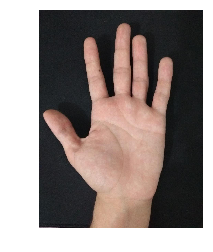

In [2]:
image = imageio.imread("handDatabase/person002_002.jpg")
plt.axis('off')
plt.imshow(image)
plt.show()

Implementa as funções para cálculo de variáveis utilizadas no algoritmo de Otsu

In [3]:
# Calculates a weigh for a class
def weigh(M, x1, x2, hist):
	return (1/M)*np.sum(hist[x1:x2])

# Calculates mean for a class
def mean(x1, x2, hist):

	a = 0 

	for i in range(x1, x2):
		a = a+(i*hist[i])

	if np.sum(hist[x1:x2]) != 0:
		return a/(np.sum(hist[x1:x2]))
	else: 
		return 0

# Calculates variance for a class
def variance(x1, x2, mean, hist):

	a = 0

	for i in range(x1, x2):
		a = a+(math.pow(i-mean, 2)*hist[i])

	if np.sum(hist[x1:x2]) != 0:
		return a/(np.sum(hist[x1:x2]))
	else: 
		return 0

Transformação da imagem RGB para escala de cinza

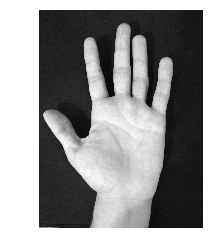

In [4]:
def grayTransform(img):
	return np.dot(img, [0.299, 0.587, 0.114])

gray = grayTransform(image).astype(int)

plt.axis('off')
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.show()

Implementação do algoritmo de Otsu, que detecta automaticamente o melhor thresholding a ser utilizado na imagem para conversão da imagem para binário

In [5]:
def otsuThresholding(img):

	# Computing histogram
	hist, bin_edges = np.histogram(img, bins='auto');
	# Converts array with edges to int
	bin_edges = bin_edges.astype(int)

	# New array to histogram
	histogram = np.zeros(255)

	# Fills new histogram
	for x in range(hist.size):
		histogram[bin_edges[x]] = hist[x]

	# Converts to int
	histogram = histogram.astype(int)

	intraclassVar = np.zeros(histogram.size)

	# Intra-class variance for each intensity
	for L in range(histogram.size):
		
		# Weigh for class A, sum of frequencies from 0 to L-1
		weighA = weigh(img.shape[0]*img.shape[1], 0, L, histogram)
		# Mean for class A
		meanA = mean(0, L+1, histogram)
		# Variance for class A
		varA = variance(0, L+1, meanA, histogram)

		# Weigh for class B, sum of frequencies from L to last item
		weighB = weigh(img.shape[0]*img.shape[1], L, histogram.size, histogram)
		# Mean for class B
		meanB = mean(L, histogram.size, histogram)
		# Variance for class B
		varB = variance(L, histogram.size, meanB, histogram)
		
		# Stores intraclass variance calculated
		intraclassVar[L] = weighA*varA + weighB*varB

		# Set the min value 
		if L is 0:
			minValue = intraclassVar[L]
		elif L != 0 and minValue > intraclassVar[L]: 
			minValue = intraclassVar[L] 

	# Returns the optimal thresholding
	return list(intraclassVar).index(minValue)

thresholding = otsuThresholding(gray)

Realiza a conversão da imagem para binário utilizando o thresholding obtido

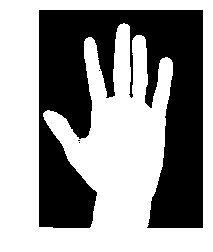

In [6]:
def binaryTransform(img, thresholding):

	binImg = np.zeros(img.shape)

	# Sets image values according to chosen thresholding
	for x in range(img.shape[0]):
		for y in range(img.shape[1]):
			if img[x,y] > thresholding: binImg[x,y] = 1

	plt.axis('off')
	plt.imshow(binImg, cmap=plt.get_cmap('gray'))
	plt.show()

	return binImg

binImg = binaryTransform(gray, thresholding)

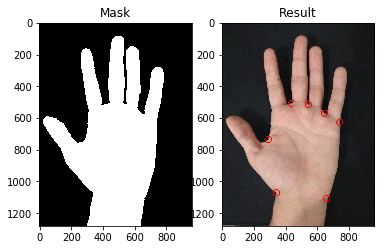

In [7]:
    def edgeDetection(binImg, image):

        binary = binImg.astype(np.uint8)

        # Reads the binary image
        img = image.astype(np.uint8)

        # Finding contours
        im2, contours, hierarchy = cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

        # Finding the biggest contour
        cnt = None
        cntArea = 0
        for i in range(len(contours)):
            if cv2.contourArea(contours[i]) > cntArea:
                cnt = contours[i]
                cntArea = cv2.contourArea(contours[i])

        # Drawing the contour in the original image
        mask = np.zeros_like(binary)
        cv2.drawContours(mask, [cnt], -1, (255), -1)
    #     cv2.drawContours(img, cnt, -1, (0,255,0), 1)

        #generating convex hull and convexity defects
        hull = cv2.convexHull(cnt, returnPoints = False)
        old_defects = cv2.convexityDefects(cnt, hull)

        #iterating through defects and checking for defects that are too small
        defects = []
        for i in range(old_defects.shape[0]):
            s,e,f,d = old_defects[i,0]
            # if distance from defect to hull is smaller than 4000, continue
            if d < 4000:
                continue;
            # drawing the defects and the hull
    #         start = tuple(cnt[s][0])
    #         end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
    #         cv2.line(img,start,end,[0,0,255],9)
            cv2.circle(img,far,20,[255,0,0], 3)
            # adding the big defects to a new array
            defects.append(old_defects[i])

        #returns the original image with everything drawed, the binary mask, the contour of the mask, the convex hull and the convex defects
        return (img, mask, cnt, np.array(defects))

    res = edgeDetection(binImg, image)

    plt.subplot(121)
    plt.title('Mask')
    plt.imshow(res[1], cmap='gray')


    plt.subplot(122)
    plt.title('Result')
    plt.imshow(res[0])

    plt.show()

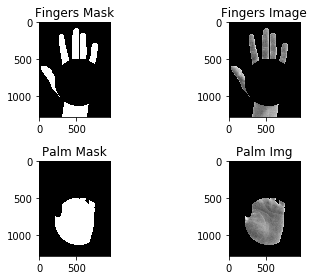

In [8]:
def cutFingersPalm(image, mask, cnt, defects):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Finding cut points
    points = []
    for i in range(defects.shape[0]):
        start = tuple( cnt[defects[i  ,0,2]][0] )
        points.append(start)
    
    # Adjusting the array for minEnclosingCircle
    # Needs to be an array of format (ROWSx1x2), where each row has a tuple with (1, (x,y) ), x and y coordinates of each point
    array = np.array(points)
    array = array.reshape((-1,1,2))
    
    # calculates the minimum enclosing circle of the hand
    (x,y),radius = cv2.minEnclosingCircle(array)
    center = (int(x),int(y))
    radius = int(radius)
    
    # Cutting hand from fingers_mask
    fingers_mask = np.copy(mask)
    cv2.circle(fingers_mask,center,radius,(0),-1)
    
    # Cutting fingers from image
    fingers_image = img*(fingers_mask.astype(image.dtype))
    
    # Drawing palm_mask. Palm mask is an AND between the minEnclosingCircle and mask
    palm_mask = np.zeros_like(mask)
    cv2.circle(palm_mask,center,radius,(255),-1)
    palm_mask = cv2.bitwise_and(palm_mask, mask)
    
    # Cutting the palm from the original image
    palm_image = img * (palm_mask.astype(image.dtype))
    
    return (fingers_mask, fingers_image, palm_mask, palm_image)
    
    
fingers_mask, fingers_image, palm_mask, palm_image = cutFingersPalm(image, res[1], res[2], res[3])

plt.subplot(221)
plt.title('Fingers Mask')
plt.imshow(fingers_mask, cmap='gray')

plt.subplot(222)
plt.title('Fingers Image')
plt.imshow(fingers_image, cmap='gray')

plt.subplot(223)
plt.title('Palm Mask')
plt.imshow(palm_mask, cmap='gray')

plt.subplot(224)
plt.title('Palm Img')
plt.imshow(palm_image, cmap='gray')

plt.tight_layout()
plt.show()

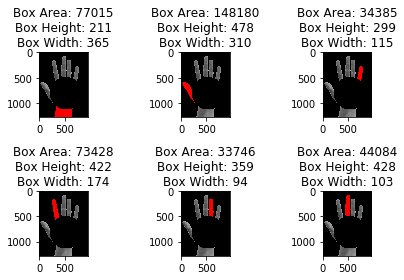

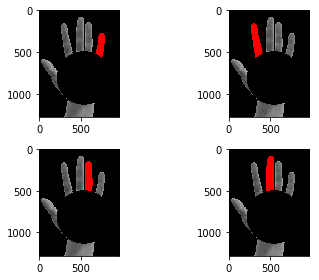

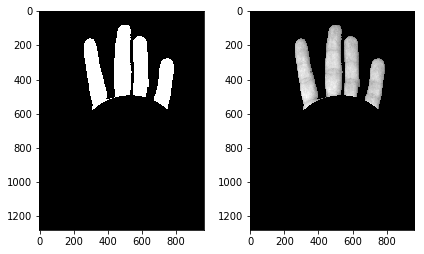

4


In [9]:
def removeArm(fingers_mask, fingers_img):
    
    # Finding contours
    im2, contours, hierarchy = cv2.findContours(fingers_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 10000]
    
    # Generates a Bounding Rectangle for each contour
    rects = [cv2.boundingRect(c) for c in contours]
    
    # Plotting stuff
    plt.figure('Before removing Thumb and Arm')
    for c, r, i in zip(contours, rects, range(1,len(contours)+1)):
        # Getting Bouding rect coords
        w, h = r[2:]
        # Generating a new image for plotting
        testImage = cv2.cvtColor(fingers_img,cv2.COLOR_GRAY2BGR)
        # Drawing the finger contour filled with red 
        cv2.drawContours(testImage, [c], -1, (255,0,0), -1)
        # creating subplots
        plt.subplot(2,3,i)
        plt.title('Box Area: ' + str(w * h) + '\nBox Height: ' + str(h) + '\nBox Width: ' + str(w))
        plt.imshow(testImage)
    
    # Showing Plots
    plt.tight_layout()
    plt.show()
    
    # Removes Contour with smallest with minimum Bouding Rectangle height (arm)
    min_h = float('inf')
    min_rect = -1
    for i in range(len(rects)):
        if(rects[i][3] < min_h):
            min_rect = i
            min_h = rects[i][3]
    rects.remove(rects[min_rect])
    contours.remove(contours[min_rect])
            
    # Removes Contour with biggest Bounding Rectangle area (thumb)
    max_a = float('-inf')
    max_rect = -1
    for i in range(len(rects)):
        if((rects[i][3] * rects[i][2]) > max_a):
            max_rect = i
            max_a = (rects[i][3] * rects[i][2])
    rects.remove(rects[min_rect])
    contours.remove(contours[min_rect])
    
    # Plotting Stuff
    plt.figure('After Removing Thumb and Arm')
    for c, r, i in zip(contours, rects, range(1,len(contours)+1)):
        # Getting Bouding rect coords
        w, h = r[2:]
        # Generating a new image for plotting
        testImage = cv2.cvtColor(fingers_img,cv2.COLOR_GRAY2BGR)
        # Drawing the finger contour filled with red 
        cv2.drawContours(testImage, [c], -1, (255,0,0), -1)
        # creating subplots
        plt.subplot(2,2,i)
        plt.imshow(testImage)
        
    # Showing Plots
    plt.tight_layout()
    plt.show()
    
    # Creating new fingers_mask and fingers_image
    new_mask = np.zeros_like(fingers_mask)
    for c in contours:
        cv2.drawContours(new_mask, [c], -1, (255), -1)
    new_image = fingers_image * (new_mask.astype(fingers_image.dtype))
        
    return (new_mask, new_image, contours)
    
new_mask, new_image, contours = removeArm(fingers_mask, fingers_image)

# Plotting stuff
plt.figure('Result:')
plt.subplot(1,2,1)
plt.imshow(new_mask, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(new_image, cmap='gray')
plt.tight_layout()
plt.show()

print(len(contours))

In [10]:
def attributeMeasure(attr):

    # Finds the fingers contours
    im2, contours, hierarchy = cv2.findContours(attr,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # Calculating the bounding box
    x, y, height, width = cv2.boundingRect(contours[0])

    return (height, width)

# Calculates palm and hand measures
palm_measure = attributeMeasure(palm_mask)

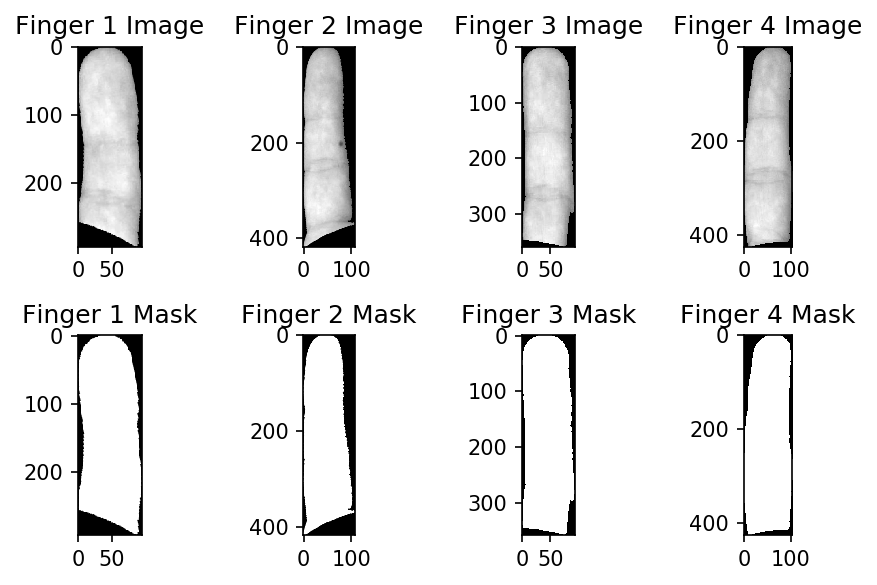

In [11]:
def isolateFingers(fingers_mask, fingers_image, contours):
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    fingers_mask = cv2.morphologyEx(fingers_mask, cv2.MORPH_OPEN, kernel)
    fingers_image = fingers_image * (fingers_mask.astype(fingers_image.dtype))
    im2, contours, hierarchy = cv2.findContours(fingers_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # Fingers holds an image for each finger
    # Fingers_masks contains a binary mask of each finger
    # Fingers_images contains an grayscale image of each finger
    fingers_masks = []
    fingers_images = []
    
    for c, i in zip(contours, range(len(contours))):
        
        # Creating the new images
        fingers_masks.append(np.zeros_like(fingers_mask))
        fingers_images.append(None)
        
        # Drawing finger mask
        cv2.drawContours(fingers_masks[i], [c], -1, (255), -1) 
        # Drawing finger image
        fingers_images[i] = fingers_image * (fingers_masks[i].astype(fingers_image.dtype))
        
        # Generating rotated bounding rectangle
        rect = cv2.minAreaRect(c)
        
        # Changes rotation angle so fingers are always on horizontal.
        # This code might be wrong, need to check corner cases
        rot = rect[2] if rect[2] > -45 else rect[2] + 90 
        rotation_matrix = cv2.getRotationMatrix2D(rect[0], rot, 1.0)
        
        # Applies rotation to mask and image
        rotated_mask = cv2.warpAffine(fingers_masks[i], rotation_matrix, fingers_masks[i].shape[:2])
        # Applies rotation
        rotated_image = cv2.warpAffine(fingers_images[i], rotation_matrix, fingers_images[i].shape[:2])
        
        # Finding contour
        cont = cv2.findContours(rotated_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
        # Getting new bouding rect
        x, y, w, h = cv2.boundingRect(cont[0])
        
        # Cropping finger mask and image
        fingers_masks[i] = np.zeros((w,h))
        fingers_images[i] = np.zeros((w,h))
        fingers_masks[i] = rotated_mask[y:y+h , x:x+w]
        fingers_images[i] = rotated_image[y:y+h , x:x+w]
        
    #returns a list containing each finger tuple(mask, image, contour)
    return [(mask, image, contour) for mask, image, contour in zip(fingers_masks, fingers_images, contours)]
    
    
fingers = isolateFingers(new_mask, new_image, contours)

# Plotting results
plt.figure('Resultados: Dedos Isolados e suas Máscaras Binárias', dpi=150)
fing_measure = []

for finger, i in zip( fingers, range(1, len(fingers) + 1) ):

    fing_mask, fing_image, fing_contour = finger

    # Adds finger measure to array
    fing_measure.append(attributeMeasure(fing_mask))

    plt.subplot(2,4,i)
    plt.title('Finger {0} Image'.format(i))
    plt.imshow(fing_image, cmap='gray')
    
    plt.subplot(2,4,i + 4)
    plt.title('Finger {0} Mask'.format(i))
    plt.imshow(fing_mask, cmap='gray')
    
plt.tight_layout()
plt.show()

In [12]:
print(palm_measure)
print(fing_measure)

(536, 640)
[(94, 294), (107, 418), (94, 359), (103, 426)]
